In [1]:
import sys
import scipy.io
import numpy as np
sys.path.append('../src')
import pandas as pd
import matplotlib.pyplot as plt
from mvt_brr import MVTModel
from scipy.optimize import minimize
# from scipy.stats import pearsonr
from world import Patch, Agent
# from simulation import Simulation

In [2]:
class StochasticChoiceModel:
    def __init__(self, beta, intercept=0):
        self.beta = beta
        self.intercept = intercept

    def leave_proba(self, reward):
        """ Compute the probability of leaving given the reward. """
        return 1 / (1 + np.exp(self.intercept + self.beta * reward))

In [5]:
def simulate_agent_in_patch(agent, patch, max_timesteps=20):
    patch.start_harvesting()
    leave_probs = []
    cumulative_prob = 1.0  # Probability of not leaving until now
    expected_leave_time = 0.0
    variance_leave_time = 0.0

    for n in range(1, max_timesteps + 1):
        reward = patch.get_reward()
        prob_leave_now = agent.get_leave_probability(reward)
        prob_leave_n = prob_leave_now * cumulative_prob
        leave_probs.append(prob_leave_now)
        # print(n, n * prob_leave_n)
        expected_leave_time += n * prob_leave_n
        cumulative_prob *= (1 - prob_leave_now)  # Update the cumulative probability

    # Calculating variance
    cumulative_prob = 1.0  # Reset for variance calculation
    for n in range(1, max_timesteps + 1):
        prob_leave_n = leave_probs[n-1] * cumulative_prob
        variance_leave_time += ((n - expected_leave_time) ** 2) * prob_leave_n
        cumulative_prob *= (1 - leave_probs[n-1])

    return expected_leave_time, variance_leave_time

In [6]:
# Example parameters
beta, intercept = 0.3, -3
stochastic_agent = Agent(policy_type='softmax', beta=beta, intercept=intercept)

patches = {
    'low': Patch(32.5, 0.075, 'exponential'),
    'med': Patch(45, 0.075, 'exponential'),
    'high': Patch(57.5, 0.075, 'exponential')
}

# Run simulations and display results
results = {}
for name, patch in patches.items():
    expected_time, variance_time = simulate_agent_in_patch(stochastic_agent, patch)
    results[name] = {'Expected Leave Time': expected_time, 'Variance': variance_time}

for patch, res in results.items():
    print(f"Patch: {patch}, Expected Leave Time: {res['Expected Leave Time']:.2f}, Variance: {res['Variance']:.4f}")

Patch: low, Expected Leave Time: 11.89, Variance: 10.2753
Patch: med, Expected Leave Time: 14.36, Variance: 9.1873
Patch: high, Expected Leave Time: 10.55, Variance: 32.1268


In [7]:
data = scipy.io.loadmat('../leheron_trialbytrial/leheron_blockSwitchIndex.mat')
block_order_df = pd.read_csv('../leheron_trialbytrial/leheron_blockOrder.csv')
df_trials = pd.read_csv("../leheron_trialbytrial/leheron_trialbytrial.csv")

In [8]:
grouped_df = df_trials.groupby(['sub', 'env', 'patch']).agg(
    mean_leaveT=('leaveT', 'mean'),
    count=('leaveT', 'count')
).reset_index()
print(grouped_df.head())

   sub  env  patch  mean_leaveT  count
0    1    1      1    33.801510      3
1    1    1      2    43.101277      3
2    1    1      3    56.137283      6
3    1    2      1    29.041616      7
4    1    2      2    39.161016      5


In [10]:
def simulate_agent_in_patch(beta, intercept, patch, max_timesteps=200):
    agent = Agent(policy_type='softmax', beta=beta, intercept=intercept)
    patch.start_harvesting()
    cumulative_prob = 1.0  # Probability of not leaving until now
    expected_leave_time = 0.0

    for n in range(1, max_timesteps + 1):
        reward = patch.get_reward()

        prob_leave_now = agent.get_leave_probability(reward)
        prob_leave_n = prob_leave_now * cumulative_prob
        expected_leave_time += n * prob_leave_n
        cumulative_prob *= (1 - prob_leave_now)  # Update the cumulative probability

    return expected_leave_time

In [11]:
def objective(params, df, patches, fix_intercept=None, fix_beta=None):
    if fix_beta is not None:
        beta = fix_beta
        intercept = params[0]
    elif fix_intercept is not None:
        beta = params[0]
        intercept = fix_intercept
    else:
        beta, intercept = params

    total_error = 0
    total_count = df['count'].sum()
    patch_mapping = {1: 'low', 2: 'med', 3: 'high'}
    
    for _, row in df.iterrows():
        patch_type, actual_mean, count = row['patch'], row['mean_leaveT'], row['count']
        patch_name = patch_mapping[patch_type]
        patch = patches[patch_name]
        predicted_mean = simulate_agent_in_patch(beta, intercept, patch)
        error = count * (predicted_mean - actual_mean) ** 2
        total_error += error
        
    rmse = np.sqrt(total_error / total_count)
    return rmse

In [12]:
def fit_parameters_for_subject(df_sub, patches):
    initial_guess = [0.3, -3]
    result = minimize(objective, initial_guess, args=(df_sub, patches), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
    fitted_beta, fitted_intercept = result.x
    return fitted_beta, fitted_intercept

In [13]:
def calculate_weighted_means(df_sub_env, fitted_beta, fitted_intercept, patches):
    weighted_predicted_leaveT = 0
    weighted_actual_leaveT = 0
    total_count = df_sub_env['count'].sum()
    patch_mapping = {1: 'low', 2: 'med', 3: 'high'}
    
    for _, row in df_sub_env.iterrows():
        patch_name = patch_mapping[row['patch']]
        patch = patches[patch_name]
        predicted_leave_time = simulate_agent_in_patch(fitted_beta, fitted_intercept, patch)
        weighted_predicted_leaveT += row['count'] * predicted_leave_time
        weighted_actual_leaveT += row['count'] * row['mean_leaveT']

    weighted_predicted_leaveT /= total_count
    weighted_actual_leaveT /= total_count
    
    return weighted_predicted_leaveT, weighted_actual_leaveT

In [14]:
def run_case_1(grouped_df, patches):
    results = []
    subject_params = {}
    
    for sub in grouped_df['sub'].unique():
        df_sub = grouped_df[grouped_df['sub'] == sub]
        fitted_beta, fitted_intercept = fit_parameters_for_subject(df_sub, patches)
        subject_params[sub] = (fitted_beta, fitted_intercept)
        
        for env in df_sub['env'].unique():
            df_sub_env = df_sub[df_sub['env'] == env]
            if not df_sub_env.empty:
                weighted_predicted_leaveT, weighted_actual_leaveT = calculate_weighted_means(df_sub_env, fitted_beta, fitted_intercept, patches)
                results.append({
                    'sub': sub,
                    'env': env,
                    'case': 'fix_beta_fix_c',
                    'fitted_beta': fitted_beta,
                    'fitted_intercept': fitted_intercept,
                    'predicted_leaveT': weighted_predicted_leaveT,
                    'actual_mean_leaveT': weighted_actual_leaveT
                })
    
    return results, subject_params

In [15]:
case_1_results, subject_params = run_case_1(grouped_df, patches)

/var/folders/fp/j9ldfbxj2_gflf_hz4bf_wyc0000gn/T/ipykernel_31139/3985341276.py:3: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(objective, initial_guess, args=(df_sub, patches), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})


Optimization terminated successfully.
         Current function value: 0.861698
         Iterations: 84
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: 3.608883
         Iterations: 101
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: 4.590397
         Iterations: 89
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 0.986642
         Iterations: 86
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 1.361019
         Iterations: 84
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 1.054548
         Iterations: 108
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: 2.028889
         Iterations: 82
         Function evaluations: 166
Optimization terminated s

In [16]:
def run_case_2(grouped_df, patches, subject_params):
    results = []
    
    for sub in grouped_df['sub'].unique():
        for env in grouped_df['env'].unique():
            df_sub_env = grouped_df[(grouped_df['sub'] == sub) & (grouped_df['env'] == env)]
            if not df_sub_env.empty:
                initial_guess = list(subject_params[sub])
                result = minimize(objective, initial_guess, args=(df_sub_env, patches), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
                fitted_beta, fitted_intercept = result.x
                weighted_predicted_leaveT, weighted_actual_leaveT = calculate_weighted_means(df_sub_env, fitted_beta, fitted_intercept, patches)
                results.append({
                    'sub': sub,
                    'env': env,
                    'case': 'vary_beta_vary_c',
                    'fitted_beta': fitted_beta,
                    'fitted_intercept': fitted_intercept,
                    'predicted_leaveT': weighted_predicted_leaveT,
                    'actual_mean_leaveT': weighted_actual_leaveT
                })
    
    return results

In [17]:
case_2_results = run_case_2(grouped_df, patches, subject_params)

Optimization terminated successfully.
         Current function value: 6.370261
         Iterations: 68
         Function evaluations: 154


/var/folders/fp/j9ldfbxj2_gflf_hz4bf_wyc0000gn/T/ipykernel_31139/4186713115.py:9: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(objective, initial_guess, args=(df_sub_env, patches), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})


Optimization terminated successfully.
         Current function value: 0.379589
         Iterations: 76
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 0.321571
         Iterations: 74
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 1.172651
         Iterations: 99
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: 0.629486
         Iterations: 80
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: 0.704506
         Iterations: 79
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 0.565369
         Iterations: 65
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 0.215539
         Iterations: 70
         Function evaluations: 137


/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:57: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(self.intercept + self.beta * reward))


Optimization terminated successfully.
         Current function value: 0.886516
         Iterations: 126
         Function evaluations: 300
Optimization terminated successfully.
         Current function value: 0.068581
         Iterations: 81
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 1.185910
         Iterations: 93
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: 1.007121
         Iterations: 69
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 1.154190
         Iterations: 97
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: 1.111397
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 1.040494
         Iterations: 76
         Function evaluations: 160
Optimization terminated su

In [20]:
def run_case_3(grouped_df, patches, subject_params):
    results = []
    
    for sub in grouped_df['sub'].unique():
        fixed_intercept = subject_params[sub][1]
        for env in grouped_df['env'].unique():
            df_sub_env = grouped_df[(grouped_df['sub'] == sub) & (grouped_df['env'] == env)]
            if not df_sub_env.empty:
                initial_guess = [subject_params[sub][0]]
                # result = minimize(objective, initial_guess, args=(df_sub_env, patches, fixed_intercept), method='nelder-mead', options={
                #                                                                                                                         'fatol': 1e-6,
                #                                                                                                                         'disp': True})
                result = minimize(objective, initial_guess, args=(df_sub_env, patches, fixed_intercept), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
                fitted_beta = result.x[0]
                weighted_predicted_leaveT, weighted_actual_leaveT = calculate_weighted_means(df_sub_env, fitted_beta, fixed_intercept, patches)
                results.append({
                    'sub': sub,
                    'env': env,
                    'case': 'vary_beta_fix_c',
                    'fitted_beta': fitted_beta,
                    'fitted_intercept': fixed_intercept,
                    'predicted_leaveT': weighted_predicted_leaveT,
                    'actual_mean_leaveT': weighted_actual_leaveT
                })
    
    return results

In [21]:
case_3_results = run_case_3(grouped_df, patches, subject_params)

Optimization terminated successfully.
         Current function value: 6.370261
         Iterations: 28
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: 2.800055
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.891562
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.534453
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 1.583654
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 2.218571
         Iterations: 24
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: 2.549326
         Iterations: 23
         Function evaluations: 46
Optimization terminated successful

In [22]:
def run_case_4(grouped_df, patches, subject_params):
    results = []
    
    for sub in grouped_df['sub'].unique():
        fixed_beta = subject_params[sub][0]
        for env in grouped_df['env'].unique():
            df_sub_env = grouped_df[(grouped_df['sub'] == sub) & (grouped_df['env'] == env)]
            if not df_sub_env.empty:
                initial_guess = [subject_params[sub][1]]
                result = minimize(objective, initial_guess, args=(df_sub_env, patches, None, fixed_beta), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
                fitted_intercept = result.x[0]
                weighted_predicted_leaveT, weighted_actual_leaveT = calculate_weighted_means(df_sub_env, fixed_beta, fitted_intercept, patches)
                results.append({
                    'sub': sub,
                    'env': env,
                    'case': 'fix_beta_vary_c',
                    'fitted_beta': fixed_beta,
                    'fitted_intercept': fitted_intercept,
                    'predicted_leaveT': weighted_predicted_leaveT,
                    'actual_mean_leaveT': weighted_actual_leaveT
                })
    
    return results

In [23]:
case_4_results = run_case_4(grouped_df, patches, subject_params)

Optimization terminated successfully.
         Current function value: 6.370261
         Iterations: 31
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: 2.800054
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 0.851042
         Iterations: 26
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 0.489891
         Iterations: 26
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 1.415566
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 2.368950
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 2.041004
         Iterations: 27
         Function evaluations: 54
Optimization terminated successful

In [24]:
all_results = case_1_results + case_2_results + case_3_results + case_4_results
results_df = pd.DataFrame(all_results)

In [25]:
results_df[results_df["sub"]==3]

,sub,env,case,fitted_beta,fitted_intercept,predicted_leaveT,actual_mean_leaveT
4,3,1,fix_beta_fix_c,0.073163,1.474161,19.548446,16.733743
5,3,2,fix_beta_fix_c,0.073163,1.474161,17.257057,20.564042
82,3,1,vary_beta_vary_c,0.364397,-4.343233,16.733739,16.733743
83,3,2,vary_beta_vary_c,0.801783,-6.513515,20.564046,20.564042
160,3,1,vary_beta_fix_c,0.057667,1.474161,16.892092,16.733743
161,3,2,vary_beta_fix_c,0.098474,1.474161,20.654309,20.564042
238,3,1,fix_beta_vary_c,0.073163,1.126248,16.765131,16.733743
239,3,2,fix_beta_vary_c,0.073163,1.829577,20.597678,20.564042


In [26]:
def calculate_rmse_for_cases(results_df):
    results = []
    
    for sub in results_df['sub'].unique():
        sub_data = results_df[results_df['sub'] == sub]
        
        for case in sub_data['case'].unique():
            case_data = sub_data[sub_data['case'] == case]
            n = len(case_data)
            rss = np.sum((case_data['actual_mean_leaveT'] - case_data['predicted_leaveT']) ** 2)
            rmse = np.sqrt(rss / n)
            results.append({
                'sub': sub,
                'case': case,
                'rmse': rmse
            })
    
    return pd.DataFrame(results)

rmse_df = calculate_rmse_for_cases(results_df)

In [27]:
def find_winning_cases(rmse_df):
    # Find the minimum RMSE for each subject
    winning_cases = rmse_df.loc[rmse_df.groupby('sub')['rmse'].idxmin()]
    
    # Count the number of subjects for each case
    case_counts = winning_cases['case'].value_counts().reindex([
        'vary_beta_vary_c', 'vary_beta_fix_c', 'fix_beta_vary_c', 'fix_beta_fix_c'
    ], fill_value=0)
    
    return case_counts, winning_cases

In [29]:
def plot_winning_cases_histogram(case_counts):
    cases = ['vary $\\beta$, vary c', 'vary $\\beta$, fix c', 'fix $\\beta$, vary c', 'fix $\\beta$, fix c']
    case_counts_sorted = [
        case_counts['vary_beta_vary_c'], 
        case_counts['vary_beta_fix_c'], 
        case_counts['fix_beta_vary_c'], 
        case_counts['fix_beta_fix_c']
    ]

    plt.figure(figsize=(4, 3))
    plt.bar(cases, case_counts_sorted, color='pink')
    plt.ylabel('Number of subjects')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [30]:
case_counts, winning_cases = find_winning_cases(rmse_df)

In [31]:
case_counts

case
vary_beta_vary_c    23
vary_beta_fix_c      6
fix_beta_vary_c     10
fix_beta_fix_c       0
Name: count, dtype: int64

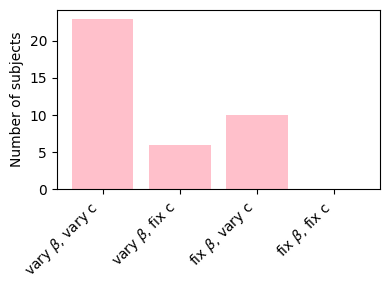

In [32]:
plot_winning_cases_histogram(case_counts)

In [33]:
df_trials.head()

,sub,patch,env,leaveT,meanLT,dmLeave
0,1,3,1,45.034784,40.532927,4.501856
1,1,2,1,44.403900,40.532927,3.870973
2,1,3,1,61.168672,40.532927,20.635745
3,1,1,1,26.803514,40.532927,-13.729413
4,1,3,1,56.992002,40.532927,16.459075


In [34]:
patch_types = [
    {'type': 'Low', 'initial_yield': 32.5, 'decay_rate': 0.075},
    {'type': 'Mid', 'initial_yield': 45, 'decay_rate': 0.075},
    {'type': 'High', 'initial_yield': 57.5, 'decay_rate': 0.075}
]
patch_type = patch_types[1]
patch_type['initial_yield']

45

In [35]:
def predict_leave_time(row, parameters, case):
    beta = parameters.loc[(parameters['sub'] == row['sub']) & (parameters['env'] == row['env']) & (parameters['case'] == case), 'fitted_beta'].values[0]
    intercept = parameters.loc[(parameters['sub'] == row['sub']) & (parameters['env'] == row['env']) & (parameters['case'] == case), 'fitted_intercept'].values[0]
    patch_type = patch_types[int(row['patch']-1)]
    patch = Patch(patch_type['initial_yield'], patch_type['decay_rate'])
    predicted_leave_time = simulate_agent_in_patch(beta, intercept, patch, max_timesteps=200)
    
    return predicted_leave_time

In [36]:
def calculate_rmse_for_subjects(df_trials, results_df, case):
    df_trials[f'predicted_leaveT_{case}'] = df_trials.apply(predict_leave_time, axis=1, parameters=results_df, case=case)
    
    rmse_results = []
    for sub in df_trials['sub'].unique():
        sub_data = df_trials[df_trials['sub'] == sub]
        rss = np.sum((sub_data['leaveT'] - sub_data[f'predicted_leaveT_{case}']) ** 2)
        rmse = np.sqrt(rss / len(sub_data))
        rmse_results.append({'sub': sub, 'rmse': rmse, 'case': case})
    
    return pd.DataFrame(rmse_results)

In [46]:
def calculate_all_rmse(df_trials, results_df):
    cases = ['vary_beta_vary_c', 'vary_beta_fix_c', 'fix_beta_vary_c', 'fix_beta_fix_c']
    all_rmse = []

    for case in cases:
        rmse_df = calculate_rmse_for_subjects(df_trials, results_df, case)
        all_rmse.append(rmse_df)
    
    all_rmse_df = pd.concat(all_rmse, ignore_index=True)
    
    # Find the winning case with minimum RMSE for each subject
    # winning_cases = all_rmse_df.loc[all_rmse_df.groupby('sub')['rmse'].idxmin()]

    # Sum RMSE for each case
    rmse_sums = all_rmse_df.groupby('case')['rmse'].sum()

    # return all_rmse_df, winning_cases
    return all_rmse_df, rmse_sums

In [43]:
def plot_winning_cases_histogram(case_counts):
    cases = ['vary $\\beta$, vary c', 'vary $\\beta$, fix c', 'fix $\\beta$, vary c', 'fix $\\beta$, fix c']
    case_counts_sorted = [
        case_counts['vary_beta_vary_c'], 
        case_counts['vary_beta_fix_c'], 
        case_counts['fix_beta_vary_c'], 
        case_counts['fix_beta_fix_c']
    ]

    plt.figure(figsize=(4, 3))
    plt.bar(cases, case_counts_sorted, color='pink')
    plt.ylabel('Number of subjects')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [47]:
def plot_rmse_sums(rmse_sums):
    cases = ['vary_beta_vary_c', 'vary_beta_fix_c', 'fix_beta_vary_c', 'fix_beta_fix_c']
    rmse_values_sorted = [rmse_sums[case] for case in cases]

    plt.figure(figsize=(4, 5))
    plt.bar(cases, rmse_values_sorted, color='pink')
    plt.ylabel('Sum of RMSE')
    plt.ylim(150, 180)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:57: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(self.intercept + self.beta * reward))


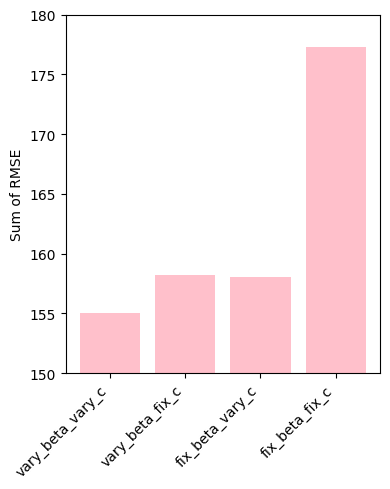

In [48]:
# Calculate RMSE for all cases and find the winning case for each subject
# all_rmse_df, winning_cases = calculate_all_rmse(df_trials, results_df)
# case_counts = winning_cases['case'].value_counts()
# plot_winning_cases_histogram(case_counts)

all_rmse_df, rmse_sums = calculate_all_rmse(df_trials, results_df)
plot_rmse_sums(rmse_sums)

In [56]:
new_res_df = pd.read_csv("../src/optimization_results_softmax.csv")
new_res_df[new_res_df["sub"]==3]

,sub,env,case,policy_type,fitted_parameter,fitted_intercept,predicted_leaveT,actual_mean_leaveT
4,3,1,fix_parameter_fix_c,softmax,0.073163,1.474161,19.548446,16.733743
5,3,2,fix_parameter_fix_c,softmax,0.073163,1.474161,17.257057,20.564042
82,3,1,vary_parameter_vary_c,softmax,0.364397,-4.343233,16.733739,16.733743
83,3,2,vary_parameter_vary_c,softmax,0.801783,-6.513515,20.564046,20.564042
160,3,1,vary_parameter_fix_c,softmax,0.057667,1.474161,16.892092,16.733743
161,3,2,vary_parameter_fix_c,softmax,0.098474,1.474161,20.654309,20.564042
238,3,1,fix_parameter_vary_c,softmax,0.073163,1.126248,16.765131,16.733743
239,3,2,fix_parameter_vary_c,softmax,0.073163,1.829577,20.597678,20.564042


In [57]:
new_rmse_df = calculate_rmse_for_cases(new_res_df)

In [60]:
case_counts, winning_cases = find_winning_cases(new_rmse_df)

In [61]:
case_counts

case
vary_beta_vary_c    0
vary_beta_fix_c     0
fix_beta_vary_c     0
fix_beta_fix_c      0
Name: count, dtype: int64

In [62]:
new_rmse_df

,sub,case,rmse
0,1,fix_parameter_fix_c,5.220099e+00
1,1,vary_parameter_vary_c,1.758770e-06
2,1,vary_parameter_fix_c,8.595456e-07
3,1,fix_parameter_vary_c,1.861098e-07
4,2,fix_parameter_fix_c,5.502129e-01
...,...,...,...
151,38,fix_parameter_vary_c,1.447092e-07
152,39,fix_parameter_fix_c,1.571767e+00
153,39,vary_parameter_vary_c,6.215521e-06
154,39,vary_parameter_fix_c,3.387905e-07
